****This work is referred from the https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb#scrollTo=DMTm4peo3cem

The used dataset is from http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/

The used case application for which we have implemented our project is from sketch to face generation and face to sketch generation


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
import cv2 as cv

In [2]:
print(tf.__version__)

2.1.0-rc0


# Load the Dataset

In [3]:
import scipy
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate,concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU,ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D,Conv2DTranspose
from tensorflow.keras import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
# from data_loader import DataLoader
import numpy as np
import os
import cv2 as cv

Using TensorFlow backend.


In [4]:
# set Direcotory

#  /root/.keras/datasets/pix2pix/
# cd /root/.keras/datasets/pix2pix/

path ='/kaggle/working'

In [5]:


!mkdir -p pix2pix/test/concat
!mkdir -p pix2pix/train/concat

In [6]:
cd pix2pix

/kaggle/working/pix2pix


In [7]:

_URL1 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_sketches.zip'

_URL2 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_photos.zip'

_URL3 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Cropped_Images/CUHK_testing_cropped_sketches.zip'

_URL4 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Cropped_Images/CUHK_testing_cropped_photos.zip'

path_to_zip1 = tf.keras.utils.get_file(path+'/pix2pix/train/CUHK_training_cropped_sketches.zip',
                                      origin=_URL1,archive_format='zip',
                                       cache_subdir=path+'/pix2pix/train',
                                      extract=True)

path_to_zip2 = tf.keras.utils.get_file(path+'/pix2pix/train/CUHK_training_cropped_photos.zip',
                                      origin=_URL2,archive_format='zip',
                                       cache_subdir=path+'/pix2pix/train',
                                      extract=True)

path_to_zip3 = tf.keras.utils.get_file(path+'/pix2pix/test/CUHK_testing_cropped_sketches.zip',
                                       cache_subdir=path+'/pix2pix/test',
                                      origin=_URL3,
                                      extract=True)

path_to_zip4 = tf.keras.utils.get_file(path+'/pix2pix/test/CUHK_testing_cropped_photos.zip',
                                      origin=_URL4,
                                       cache_subdir=path+'/pix2pix/test',
                                      extract=True)


778240/771222 [==============================] - 1s 2us/step


In [8]:
PATH1 = os.path.join(os.path.dirname(path_to_zip1), 'sketches/')

PATH2 = os.path.join(os.path.dirname(path_to_zip2), 'photos/')

PATH3 = os.path.join(os.path.dirname(path_to_zip3), 'sketches/')

PATH4 = os.path.join(os.path.dirname(path_to_zip4), 'photos/')

# Data Preprocessing

In [9]:
def numpyimage(sketch_image_file, original_image):
  image1 = cv.imread(sketch_image_file)
  image2 = cv.imread(original_image)
  return image1, image2

In [10]:
def load(sketch_image_file, original_image):
  # image1 = cv.imread(sketch_image_file)
  # image2 = cv.imread(original_image)
  image1 = tf.io.read_file(sketch_image_file)
  image1 = tf.image.decode_jpeg(image1,channels=3)


  image2 = tf.io.read_file(original_image)
  image2 = tf.image.decode_jpeg(image2,channels=3)

  
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)
  # real_image = image[:, :w, :]
  # input_image = image[:, w:, :]

  # input_image = tf.cast(image1, tf.float32)
  # real_image = tf.cast(image2, tf.float32)

  return image1, image2

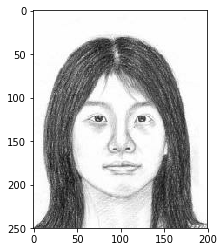

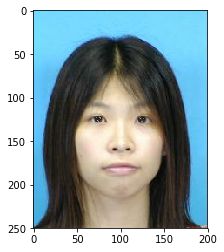

In [11]:
inp, re = load(PATH1+'F2-005-01-sz1.jpg', PATH2+'f-005-01.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [12]:
print(re.shape)

print(inp.shape)

In [13]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

(250, 200, 3)
(250, 200, 3)


In [14]:
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 256, 256)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [15]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

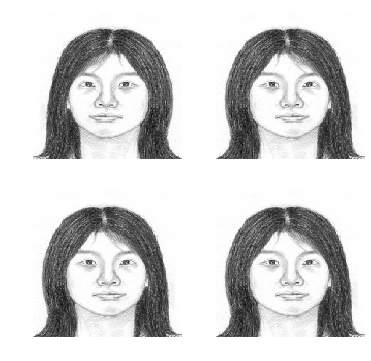

In [16]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255)
  plt.axis('off')
plt.show()

In [17]:
rj_inp.shape

TensorShape([256, 256, 3])

In [18]:
import glob
train_sketch = glob.glob(path+"/pix2pix/train/sketches/*")
train_photo = glob.glob(path+"/pix2pix/train/photos/*")

In [19]:
test_sketch = glob.glob(path+"/pix2pix/test/sketches/*")
test_photo = glob.glob(path+"/pix2pix/test/photos/*")

In [20]:
train_sketch = sorted(train_sketch)
train_photo = sorted(train_photo)

In [21]:
test_sketch = sorted(test_sketch)
test_photo = sorted(test_photo)

In [22]:
train=[]
for i in range(0,88):
  train.append(train_sketch[i]+' '+train_photo[i])



In [23]:
test=[]
for i in range(0,100):
  test.append(test_sketch[i]+' '+test_photo[i])

In [24]:
#mkdir concat make the direcory are location below if not avaiable
# /root/.keras/datasets/pix2pix/train/concat/
# /root/.keras/datasets/pix2pix/test/concat/

In [25]:
j=0
for i in train:
  im = i.split(' ')
  # print(im)
  im[0],im[1] = numpyimage(im[0], im[1])
  im_v = cv.hconcat([im[0], im[1]])
  cv.imwrite(path+'/pix2pix/train/concat/'+str(j)+'_merged.jpg', im_v)
  # plt.figure()
  # # plt.imshow(im_v/255.0)
  j = j+1

In [26]:
j=0
for i in test:
  im = i.split(' ')
  # print(im)
  im[0],im[1] = numpyimage(im[0], im[1])
  im_v = cv.hconcat([im[0], im[1]])
  cv.imwrite(path+'/pix2pix/test/concat/'+str(j)+'_merged.jpg', im_v)
  # plt.figure()
  # # plt.imshow(im_v/255.0)
  j = j+1

In [27]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [28]:
def load2(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [29]:
def load_image_train(image_file):
  input_image, real_image = load2(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [30]:
def load_image_test(image_file):
  input_image, real_image = load2(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

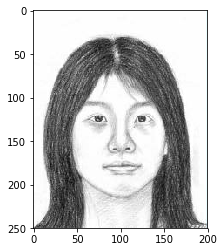

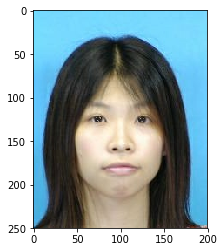

In [31]:
inp, re = load2(path+'/pix2pix/train/concat/0_merged.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [32]:
train_dataset = tf.data.Dataset.list_files(path+'/pix2pix/train/concat/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [33]:
test_dataset = tf.data.Dataset.list_files(path+'/pix2pix/test/concat/*.jpg')
test_dataset = test_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Build Generator

In [34]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(BatchNormalization())
  result.add(LeakyReLU())
  return result

In [35]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result

In [36]:
def Generator():
  inputs = Input(shape=[256,256,3])
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])
  x = last(x)
  return Model(inputs=inputs, outputs=x)

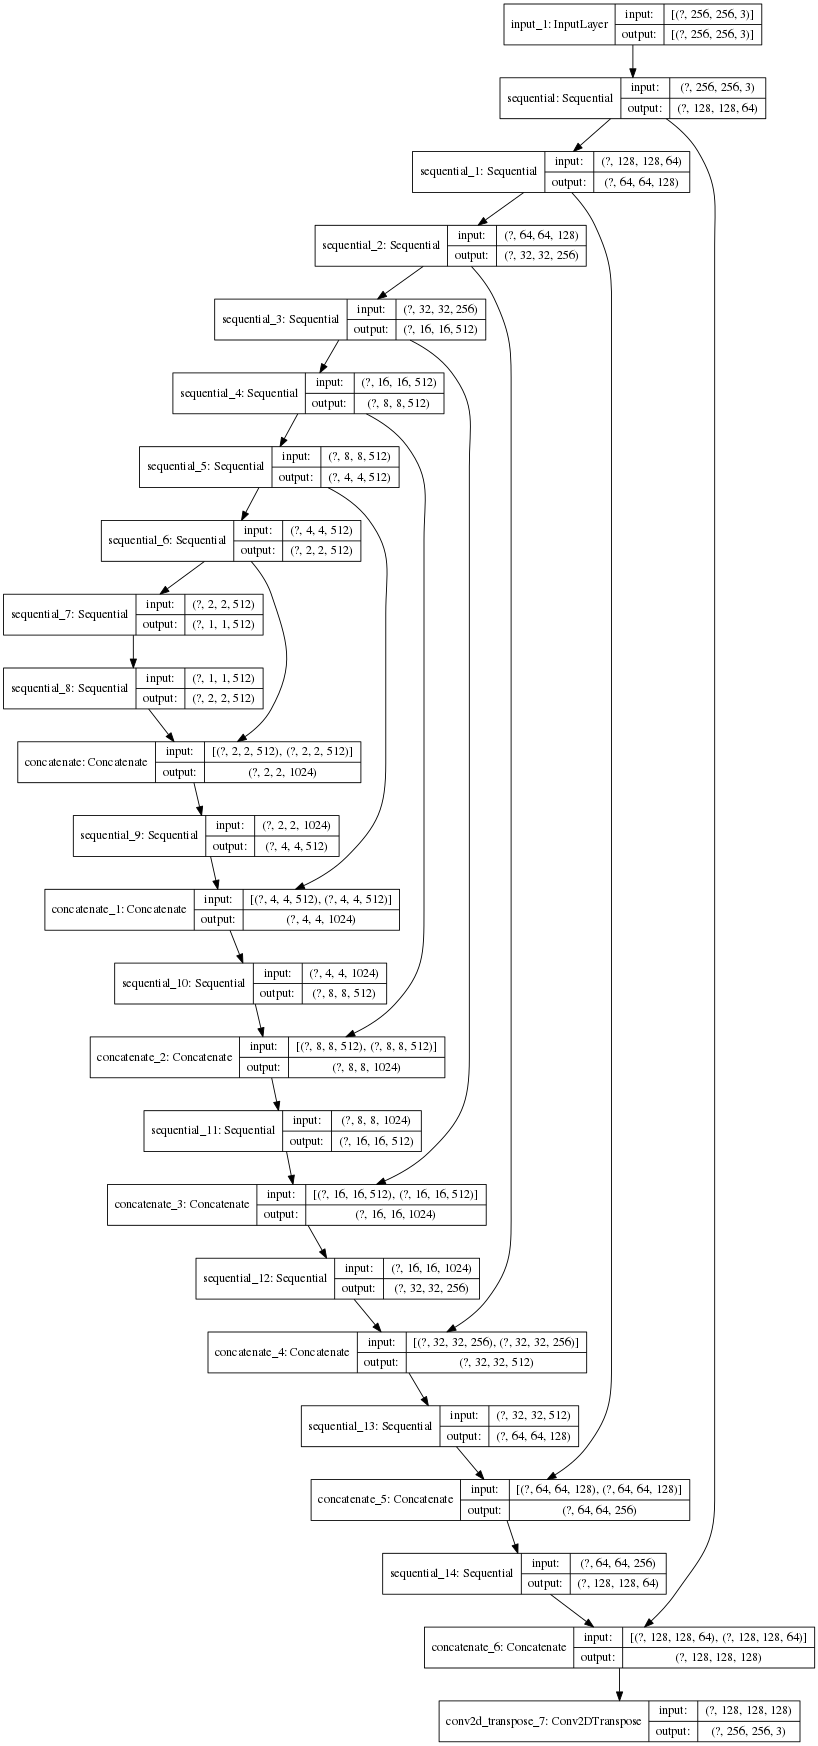

In [37]:

OUTPUT_CHANNELS = 3
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

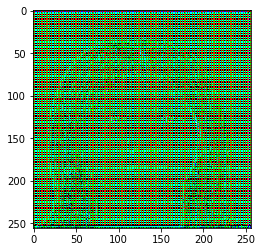

In [38]:
gen_output = generator(rj_inp[tf.newaxis,...])
plt.imshow(gen_output[0,...])

In [39]:
LAMBDA = 100 # it depends on  how our model is perfroming
# we should try with different value to see the result

In [40]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [41]:
def generator_acc(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

# Build Discriminator

In [42]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = Input(shape=[256, 256, 3], name='input_image')
  tar = Input(shape=[256, 256, 3], name='target_image')

  x = concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = BatchNormalization()(conv)

  leaky_relu = LeakyReLU()(batchnorm1)

  zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return Model(inputs=[inp, tar], outputs=last)

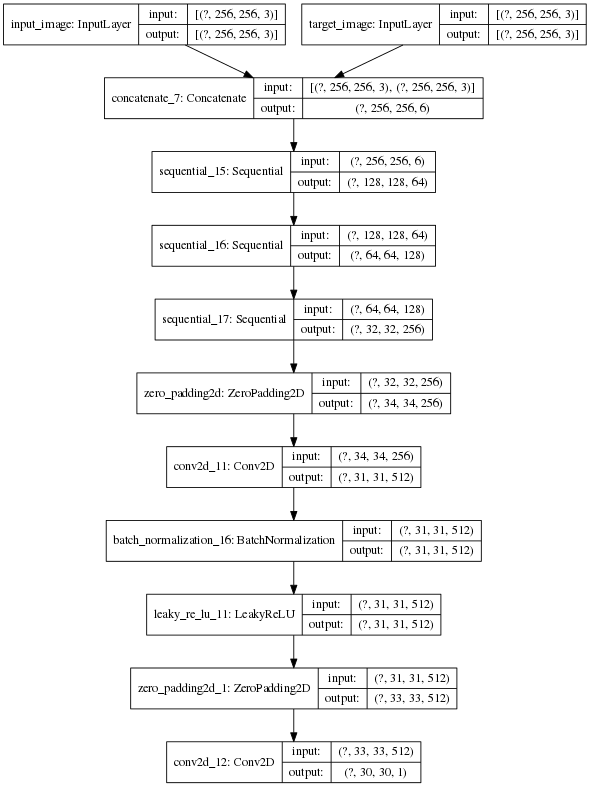

In [43]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

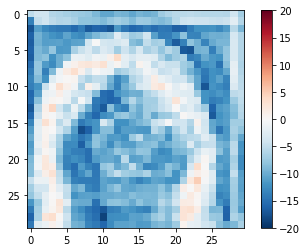

In [44]:
disc_out = discriminator([rj_inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [45]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


In [46]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Below function is to see the output of the images from the model

In [48]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  disc_out1 = discriminator([test_input[...], prediction], training=True)
  disc_out2 = discriminator([test_input[...], tar], training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0],disc_out1[0][...,-1],disc_out2[0][...,-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image','Discriminator fake','Discriminator real']

  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

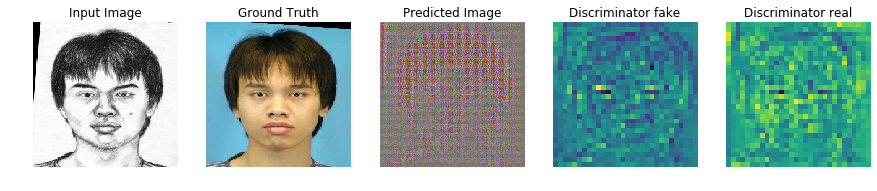

In [49]:
# we predict the image when model is untrained at the begining
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

# Training

In [50]:
EPOCHS = 10
#change to 300

# since our kernel died we ran it for the less epochs 10
# change the epoch to 300+ for better result

In [51]:
import datetime
log_dir=path+"/pix2pix/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [52]:
pwd

'/kaggle/working/pix2pix'

In [53]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)


In [54]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

#     # saving (checkpoint) the model every  epochs
#     if (epoch + 1) % 20 == 0:
#       checkpoint.save(file_prefix = checkpoint_prefix)

#     print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
#                                                         time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

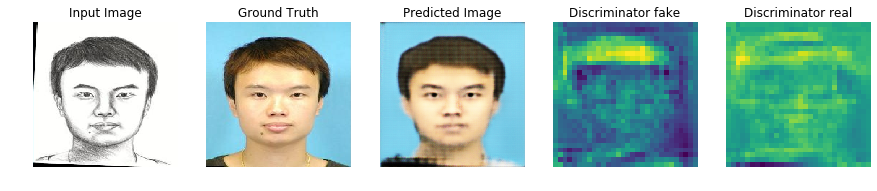

Epoch:  9
........................................................................................


In [55]:
# we are currently running for less epochs since our kernel died however our result for the 300 epochs are already mentioned below.
# change the epoch seeting to 300
fit(train_dataset, EPOCHS, test_dataset)

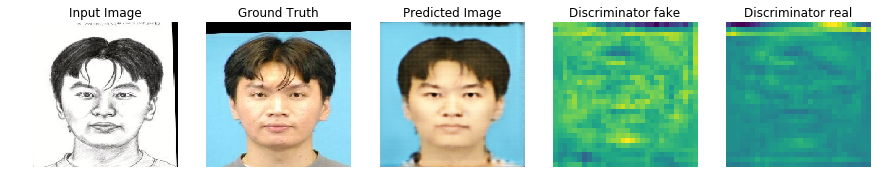

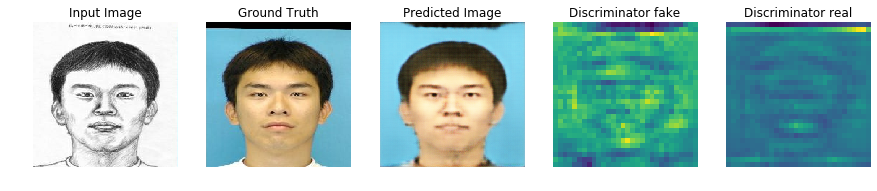

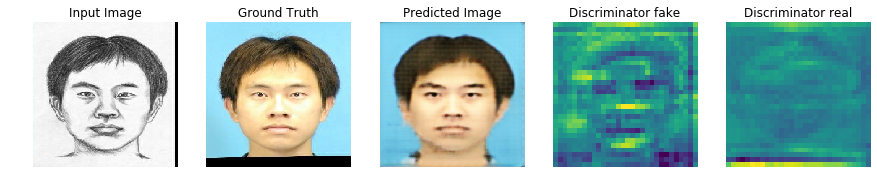

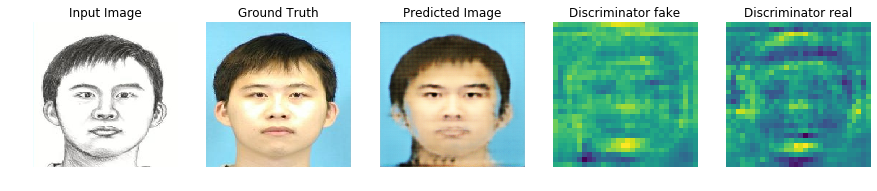

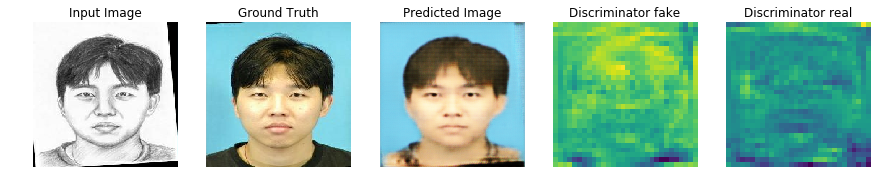

In [56]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [57]:
tf.saved_model.save(generator, path+"/pix2pix/")


In [58]:
loaded = tf.saved_model.load(path+"/pix2pix/")
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


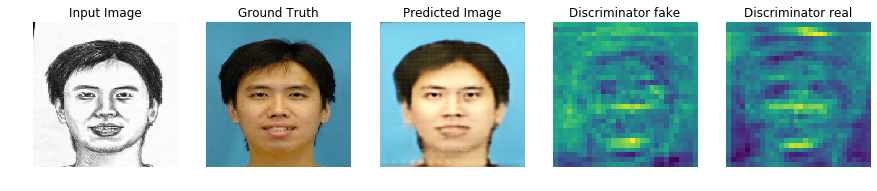

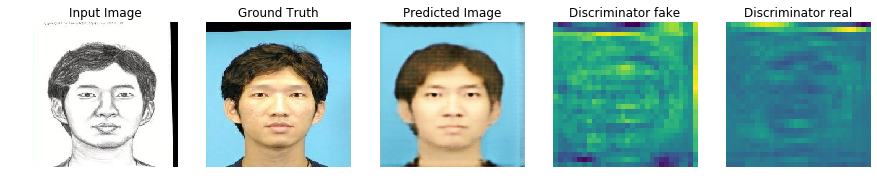

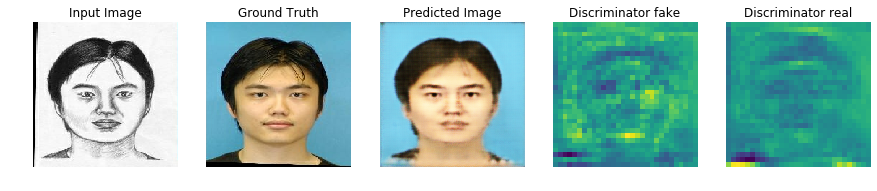

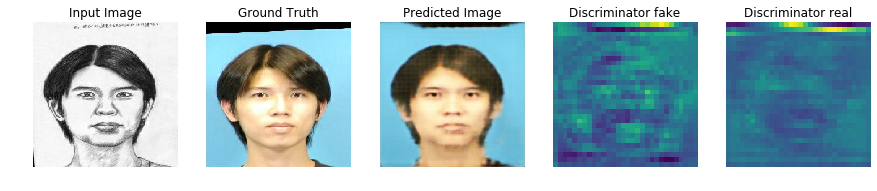

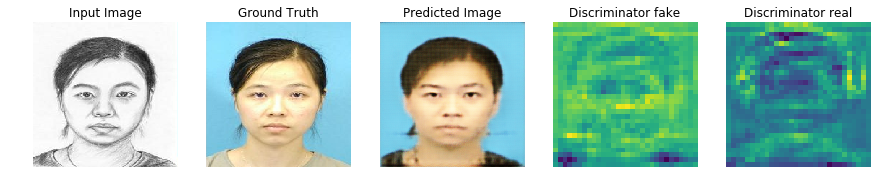

In [59]:
for inp, tar in test_dataset.take(5):
  generate_images(loaded, inp, tar)  

# Output of all the loses can be seen on below link

we have ploted three losses for the moment
dic loss
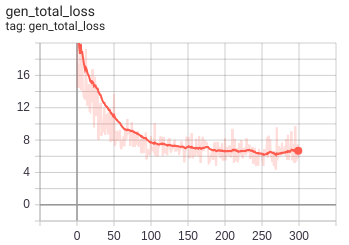
gan loss
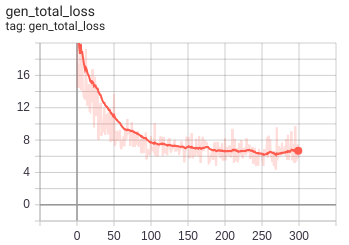
l1 loss
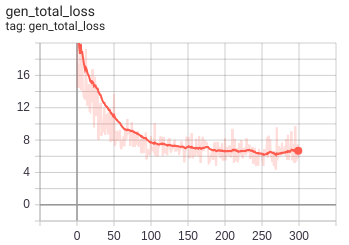
total gan loss
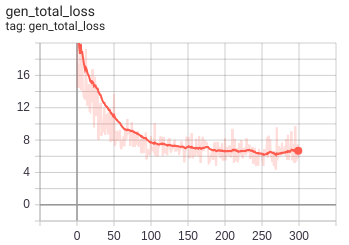

https://tensorboard.dev/experiment/kqb3403oQx28K5CBpGRUrg/#scalars&_smoothingWeight=0.945

# Refered from the notebook pix2pix
(https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb#scrollTo=DMTm4peo3cem)
#### Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

##### * Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
##### * The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
##### * For the `disc_**loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
##### * For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at fooling the descriminator.
##### * As training progresses the `gen_l1_loss` should go down.

# As per the given instruction our disc loss has been descreasing which shows generator was able to fool the descriminator as some extent. however the geneator gan loss has increased with the epochs
#